<a href="https://colab.research.google.com/github/MaicolFranco/Sales_Predictions/blob/main/Food_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [500]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Food Sales Prediction Project**

The information use in this project corresponds to 2013 sales of **1559** products and was collected by data scientist at BigMart across 10 stores in different cities. Some features of each product have been defined. In order to help to the retailer to understand the product properties and the outlets that play a crucial role in the sales, **this project aims to predict the sales of food products in each outlet, it will try to understand the properties of products and outlets which play a key role in increasing sales.**

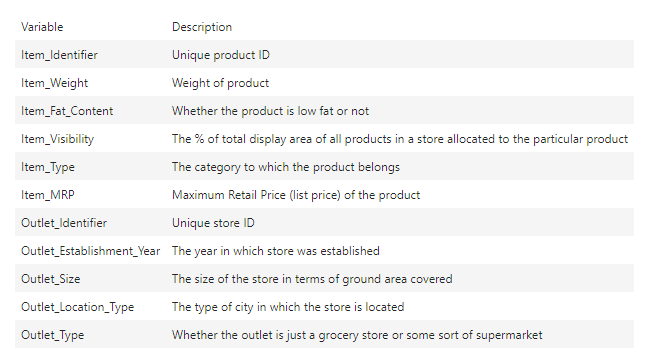

# **Importaciones Correspondientes**

In [501]:
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use("seaborn")

# **Cargo La Informacion**

In [502]:
df = pd.read_csv("/content/sales_predictions.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [503]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [504]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Observaciones:


Faltan datos en las columnas: Item_Weight: 1463 (valores faltantes) y Outlet_Size: 2410 valores faltantes.

In [505]:
df.shape

(8523, 12)

# **Limpieza De datos**

comprobemos si hay información duplicada y si es asi eliminemosla.

In [506]:
df.duplicated().sum()

0

# **Observaciones En Columnas Irrelevantes**

El peso del artículo (Item_Weight)se puede categorizar como una característica irrelevante en la predicción de ventas, asi mismo la columna (Outlet_Establishment_Year) es el año en que se estableció la tienda, por lo tanto estas dos columnas la eliminaremos.

In [507]:
df.drop(columns = ["Item_Weight", "Outlet_Establishment_Year"], inplace=True)
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052


# **Tipo De Informacion En Cada Columna**

In [508]:
df.dtypes

Item_Identifier          object
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Identifier        object
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

In [509]:
numericos = []
no_numericos = []
def validar_cols(col):
    try:
        col_max = df[col].max()
        col_min = df[col].min() 
        if col_min < 0:
            print(f"In the col**** {col}*** there is at leat a value under 0 ******* check!")
            numericos.append({col +"_min": col_min})
        if col_max > 1:
            print(f"In the col **** {col} **** there is at leat a value over 1 it makes sense? *********** check!")
            numericos.append({col + "_max": col_max})
        else:
            print(f"the next numerical col seem not to present incosistencies: {col}")
    except:
        no_numericos.append(col)
        print(f"---------column {col} not checked - not numerical col ----------------")

In [510]:
for colum in list(df.columns):
    validar_cols(colum)
print("\n","Check this values:", numericos)
print("\n", "Non mumeric columns to check: ",no_numericos)

---------column Item_Identifier not checked - not numerical col ----------------
---------column Item_Fat_Content not checked - not numerical col ----------------
the next numerical col seem not to present incosistencies: Item_Visibility
---------column Item_Type not checked - not numerical col ----------------
In the col **** Item_MRP **** there is at leat a value over 1 it makes sense? *********** check!
---------column Outlet_Identifier not checked - not numerical col ----------------
---------column Outlet_Size not checked - not numerical col ----------------
---------column Outlet_Location_Type not checked - not numerical col ----------------
---------column Outlet_Type not checked - not numerical col ----------------
In the col **** Item_Outlet_Sales **** there is at leat a value over 1 it makes sense? *********** check!

 Check this values: [{'Item_MRP_max': 266.8884}, {'Item_Outlet_Sales_max': 13086.9648}]

 Non mumeric columns to check:  ['Item_Identifier', 'Item_Fat_Content',

# **Observaciones:**

 Hay coherencia con la  información de cada columna. Ahora revisemos las columnas categoricas

In [511]:
for column in no_numericos:
    print("\n", column, df[column].unique())


 Item_Identifier ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

 Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

 Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

 Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

 Outlet_Size ['Medium' nan 'High' 'Small']

 Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']

 Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


Hay irregularidades en Item_Fat_Content; podemos decir que:

LF = Low Fat

low fat = Low Fat

reg = Regular

In [512]:
df["Item_Fat_Content"].replace(["LF","reg","low fat"],["Low Fat", "Regular","Low Fat"], inplace=True)
df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular'], dtype=object)

**Recordemos Que En Nuestra Columna (Outlet_Size) Tenemos Datos Faltantes.**

In [513]:
df[df["Outlet_Size"].isna()].shape

(2410, 10)


son 2410 los valores faltantes en las columna (Outlet_Size).

Ahora... ¿Que podriamos hacer?.

El tamaño del punto de venta podria ser una característica importante al hacer predicciones de ventas, es una buena idea agrupar la información para encontrar patrones que puedan ser útiles para tomar decisiones sobre la información faltante.

In [514]:
df.groupby(["Outlet_Type","Outlet_Location_Type","Outlet_Identifier"])["Outlet_Size"].unique()

Outlet_Type        Outlet_Location_Type  Outlet_Identifier
Grocery Store      Tier 1                OUT019                [Small]
                   Tier 3                OUT010                  [nan]
Supermarket Type1  Tier 1                OUT046                [Small]
                                         OUT049               [Medium]
                   Tier 2                OUT017                  [nan]
                                         OUT035                [Small]
                                         OUT045                  [nan]
                   Tier 3                OUT013                 [High]
Supermarket Type2  Tier 3                OUT018               [Medium]
Supermarket Type3  Tier 3                OUT027               [Medium]
Name: Outlet_Size, dtype: object

vista la estructura de la información en la columna (Outlet_Size), no es posible determinar a qué categoría pertenecen las filas con valores faltantes, por lo que se creará una nueva categoría en la función de tamaño de salida y se reemplazarán los datos faltantes. por la etiqueta "Missing".

In [515]:
df["Outlet_Size"] = df["Outlet_Size"].fillna("Missing")
df["Outlet_Size"].isna().sum()

0

# **Validacion De Mis Datos**

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       8523 non-null   object 
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Identifier     8523 non-null   object 
 6   Outlet_Size           8523 non-null   object 
 7   Outlet_Location_Type  8523 non-null   object 
 8   Outlet_Type           8523 non-null   object 
 9   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(3), object(7)
memory usage: 666.0+ KB


# **Visualización De Datos**

Ahora. Comencemos nuestro análisis de los datos examinando el marco de datos usando el método describe.

In [517]:
df.describe().round(2)

,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.00,8523.00,8523.00
mean,0.07,140.99,2181.29
std,0.05,62.28,1706.50
min,0.00,31.29,33.29
25%,0.03,93.83,834.25
50%,0.05,143.01,1794.33
75%,0.09,185.64,3101.30
max,0.33,266.89,13086.96


De lo anterior podemos decir que:

.Hay un total de 8523 observaciones.

.La media en la columna Ventas es 2181,29.

.La venta mínima es de 33,29.

.El máximo de ventas reportado fue de 13089.96. 

# **Visualizaciones:**

Llego el momento de crear histogramas y boxplots para tener una idea clara de la distribución de las ventas.

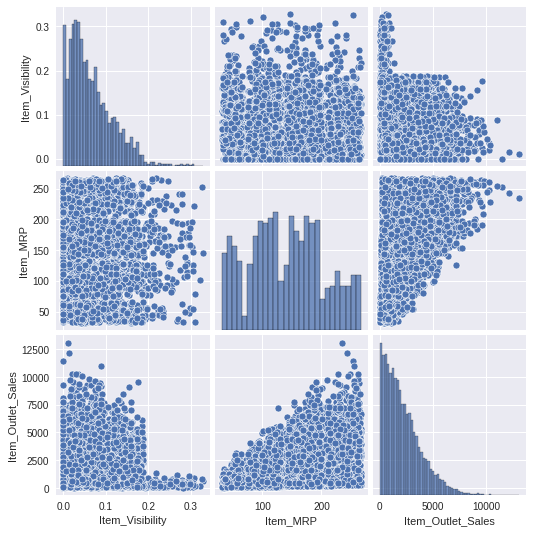

In [518]:
sns.pairplot(df)

**Observaciones:**

La distribución de las variables estudiadas no es normal, está sesgada a la derecha.

La mayoría de los productos tienen un precio entre 100 y 200.

La mayoría de los puntos de venta presentan ventas por debajo de los 2500 dólares.

La visibilidad de los productos no es normal está por debajo del 20% del área 

total de exhibición de todos los productos en una tienda.

La mayoría de los productos tienen una visibilidad entre 0 y 10%.

No existe una correlación evidente entre las variables.

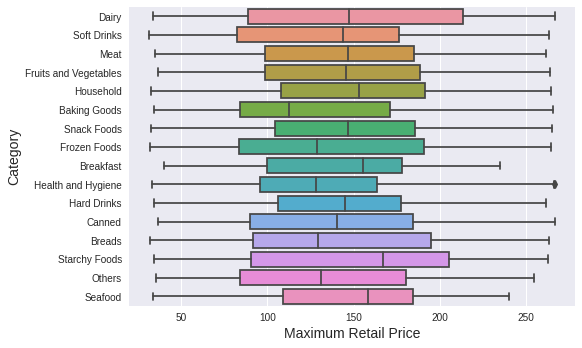

In [519]:
sns.boxplot(x='Item_MRP', y='Item_Type', data=df)
plt.ylabel("Category", fontsize=14)
plt.xlabel("Maximum Retail Price", fontsize=14)
plt.show()

**Observaciones:**

Las categorías Frutas y verduras, Hogar y Snacks son las más vendidas. Por otro lado, las categorías Desayuno, Otros y Mariscos fueron las menos vendidas.

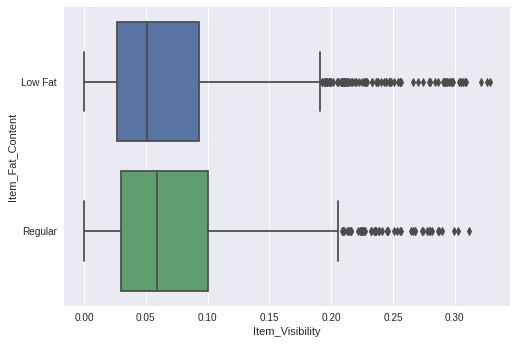

In [520]:
sns.boxplot(x='Item_Visibility', y='Item_Fat_Content', data=df)

# **Ahora Trabajaremos En La Columna Outlet_Size Y Haremos Un Correlacion.**

In [521]:
df["Outlet_Size"].unique()

array(['Medium', 'Missing', 'High', 'Small'], dtype=object)

In [522]:
df["Outlet_Location_Type"].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [523]:
colums_new = df.replace(list(df["Outlet_Size"].unique()), [2, 0, 3, 1])
colums_new.replace(list(df["Outlet_Location_Type"].unique()), [1, 2 ,3], inplace=True)
colums_new

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,2,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,0,2,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,3,2,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,0.056783,Snack Foods,214.5218,OUT013,3,2,Supermarket Type1,2778.3834
8519,FDS36,Regular,0.046982,Baking Goods,108.1570,OUT045,0,3,Supermarket Type1,549.2850
8520,NCJ29,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,1,3,Supermarket Type1,1193.1136
8521,FDN46,Regular,0.145221,Snack Foods,103.1332,OUT018,2,2,Supermarket Type2,1845.5976


In [524]:
corr = colums_new.corr()
corr.head()

,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales
Item_Visibility,1.000000,-0.001315,-0.087796,-0.076912,-0.128625
Item_MRP,-0.001315,1.000000,0.002473,0.001887,0.567574
Outlet_Size,-0.087796,0.002473,1.000000,-0.440765,0.172477
Outlet_Location_Type,-0.076912,0.001887,-0.440765,1.000000,0.099404
Item_Outlet_Sales,-0.128625,0.567574,0.172477,0.099404,1.000000


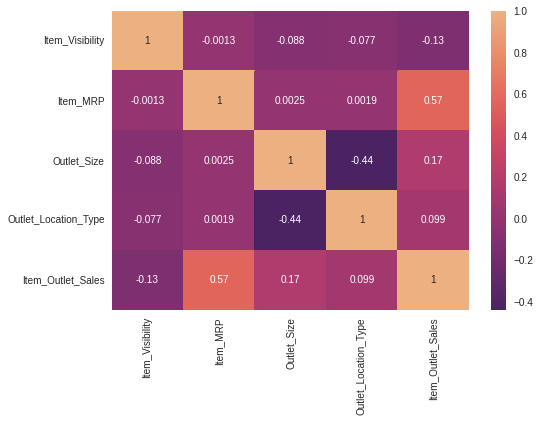

In [525]:
sns.heatmap(corr, cmap = "flare_r", annot = True)

Observaciones:

*Podriamos hacer distintas correlaciones entre las mismas columnas pero este caso hagamoslo especial, y es que vamos mirar las correlaciones con la columna Item_Outlet_Sales.
 


# **Dividiamos El Conjunto De Datos**

In [526]:
X = df.drop(columns=["Item_Outlet_Sales", "Item_Identifier"])
y = df["Item_Outlet_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       8523 non-null   object 
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Identifier     8523 non-null   object 
 6   Outlet_Size           8523 non-null   object 
 7   Outlet_Location_Type  8523 non-null   object 
 8   Outlet_Type           8523 non-null   object 
 9   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(3), object(7)
memory usage: 666.0+ KB


Al realizar la exploracion de nuestra data, podemos identificar 3 tipos de caracteristicas asi:

NUMERICAS

'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'

ORDINALES.
'Item_Fat_Content'

NOMINALES

'Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'

Para el proceso de aprendizaje de nuestro modelo sera necesario transformar nuestras caracteristicas nominales y si es el caso ordinales en variables numericas, esto para mayor funcionalidad de nuestro modelo.

In [528]:
ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# **Instanciar transformadores**

In [529]:
ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# **Instanciar Pipelines**

In [530]:
num_pipe = make_pipeline(scaler)
ord_pipe = make_pipeline(ordinal_encoder)
nomi_pipe = make_pipeline(ohe)


In [531]:
num_tuple = (num_pipe, ['Item_Visibility', 'Item_MRP'])
ord_tuple = (ord_pipe, ["Item_Fat_Content", "Outlet_Size"])
nom_tuple = (nomi_pipe, ["Item_Type", "Outlet_Identifier", "Outlet_Location_Type", "Outlet_Type"])

**Instanciar selectores de columnas**

In [532]:
cat_selector = make_column_selector(dtype_include='object')
cat_selector

In [533]:
# Nos devuelve una lista con las columnas que coinciden con el patron solicitado, en este caso, las categoricas.
cat_selector(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [534]:
num_selector = make_column_selector(dtype_include='number')
num_selector

In [535]:
#Nos devuelve una lista con las columnas que coinciden con el patron solicitado, en este caso, las numericas.
num_selector(X_train)

['Item_Visibility', 'Item_MRP']

# **Instanciar ColumnTransformer**

In [536]:
preprocessor = make_column_transformer(num_tuple, ord_tuple, nom_tuple)
preprocessor



ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Visibility', 'Item_MRP']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Item_Fat_Content', 'Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Outlet_Identifier',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

In [537]:
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Visibility', 'Item_MRP']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Item_Fat_Content', 'Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Outlet_Identifier',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

In [538]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [539]:
X_train_processed

array([[-0.71277507,  1.82810922,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

# **Inspencionar Los Resultados.**

In [540]:
print(np.isnan(X_train_processed).sum().sum(), 'valores faltantes en datos de entrenamiento')
print(np.isnan(X_test_processed).sum().sum(), 'valores faltantes en datos de prueba')
print('\n')
print('Toda la data en X_train_processed es', X_train_processed.dtype)
print('Toda la data en X_test_processed es', X_test_processed.dtype)
print('\n')
print('shape de la data es', X_train_processed.shape)
print('\n')
X_train_processed

0 valores faltantes en datos de entrenamiento
0 valores faltantes en datos de prueba


Toda la data en X_train_processed es float64
Toda la data en X_test_processed es float64


shape de la data es (6392, 37)




array([[-0.71277507,  1.82810922,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

# **modelo de regresión lineal.**

In [541]:
from sklearn.linear_model import LinearRegression

In [542]:
X = df.drop(columns=["Item_Outlet_Sales", "Item_Identifier"])
y = df["Item_Outlet_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [543]:
reg_lin = LinearRegression

In [544]:
#instanciar mi modelo
from sklearn.ensemble import RandomForestRegressor
reg_lin = RandomForestRegressor(random_state = 42, max_depth=5)

In [545]:
reg_lin.fit(X_train_processed, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [546]:
dec_train = reg_lin.predict(X_train_processed)
print(dec_train)
dec_test =reg_lin.predict(X_test_processed)
print(X_test_processed)

[3827.41739718 2892.94784768 2558.91506031 ... 3941.9951944  1981.92478523
 1508.85062056]
[[-0.77664625 -0.99881554  0.         ...  1.          0.
   0.        ]
 [ 0.1003166  -1.58519423  0.         ...  1.          0.
   0.        ]
 [-0.48299432 -1.59578435  1.         ...  1.          0.
   0.        ]
 ...
 [ 1.21832428  1.09397975  0.         ...  1.          0.
   0.        ]
 [-0.77809567 -0.36679966  0.         ...  1.          0.
   0.        ]
 [-0.77976293  0.11221189  0.         ...  1.          0.
   0.        ]]


Observaciones: en estos momentos vemos que tanto nuestro modelo de entrenamiento como el de prueba son muy pero muy bajos asi que haremos un par de ajustes.

In [547]:
# Lista de valores a probar para max_depth:
max_depth_range = list(range(2, 40))

R2 = []
for depth in max_depth_range:
    dec_lin = RandomForestRegressor(max_depth = depth, 
                             random_state = 42)
    dec_lin.fit(X_train_processed, y_train)
    score = dec_lin.score(X_test_processed, y_test)
    R2.append(score) 

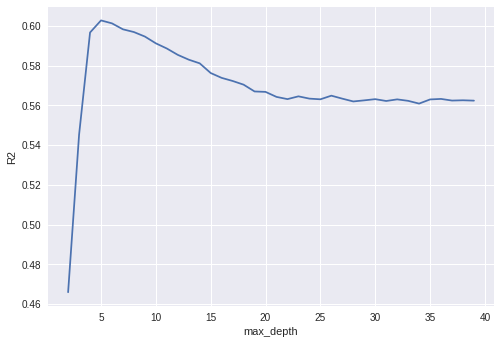

In [548]:
plt.plot(max_depth_range, R2)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [549]:
train_score = reg_lin.score(X_train_processed, y_train)
print(train_score)
test_score = reg_lin.score (X_test_processed, y_test)
print(test_score)

0.6105336252297058
0.6027139750874382


# **Rendimiento En R^2.**

In [550]:
mae_train = mean_absolute_error(y_train, dec_train) 
print('el valor metrico del error absoluto en mi modelo de entrenamiento es:', mae_train)
mae_test = mean_absolute_error(y_test, dec_test)
print('el valor metrico del error absoluto en mi modelo de prueba es:', mae_test)

el valor metrico del error absoluto en mi modelo de entrenamiento es: 755.421279978707
el valor metrico del error absoluto en mi modelo de prueba es: 728.4597726372264


**Rendimiento En  RECM.**

In [551]:
rmse_test = np.sqrt(mean_squared_error(y_test, dec_test))
rmse_test

1046.9494350238444

en este caso utlizamos el conjunto de prueba y, tengamos en cuenta que esta métrica es útil porque las unidades estarán en las mismas unidas del vector objetivo. En este caso mil dólares.

# **Arbol De Regresión.**

In [552]:
X = df.drop(columns=["Item_Outlet_Sales", "Item_Identifier"])
y = df["Item_Outlet_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [553]:

dec_tree = DecisionTreeRegressor(random_state = 42, max_depth=5)

In [554]:
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [555]:
dec_train_2 = dec_tree.predict(X_train_processed)
print(dec_train_2)
dec_test_2 = dec_tree.predict(X_test_processed)
print(dec_test_2)

[4055.65012805 3008.58568342 2516.85180062 ... 4055.65012805 2023.02155059
 1512.48967824]
[1141.52015273  730.15156837  730.15156837 ... 3587.40287949 2023.02155059
 2516.85180062]


In [556]:
train_score = dec_tree.score(X_train_processed, y_train)
print(train_score)
test_score = dec_tree.score(X_test_processed, y_test)
print(test_score)

0.6039254897160836
0.5947470502499344


Logramos ver que tanto con nuestro modelo de regresion tenemos muy bajos predicciones.


**rendimiento del modelo basándose en r^2.**

In [557]:
mae_train = mean_absolute_error(y_train, dec_train_2) 
print('el valor metrico del error absoluto en mi modelo de entrenamiento es:', mae_train)
mae_test = mean_absolute_error(y_test, dec_test_2)
print('el valor metrico del error absoluto en mi modelo de prueba es:', mae_test)

el valor metrico del error absoluto en mi modelo de entrenamiento es: 762.5844197621125
el valor metrico del error absoluto en mi modelo de prueba es: 738.3375677211942


 **rendimiento del modelo basándose en RECM.**

In [558]:
rmse_test = np.sqrt(mean_squared_error(y_test, dec_test_2))
rmse_test


1057.3947626960721

 QUE MODELO RECOMENDAR?

los dos modelos vemos que son muy utliles para problemas con nuestras predicciones pero tenieno en cuenta varios factores como trabaja cada uno y que ventajas y desvajas tienen.

al fin del dia en casos de regresion se no hace mas facil y mas diseñado trabajar con **Arboles De Regresion** esto a base de que nuestro modelo es supervisado, es muy facil de entender, tiene algo muy imortante y es una forma muy eficaz para identificar las variables más significativas, asi mismo se requiere menos limpieza de datos lo cual es algo muy util a la hora de estar trabajando en diferentes proyectos.